## **autocorrelación**

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.signal as signal
import sys
sys.path.append('../Librerias')
import dataset as ds

sns.set_style('darkgrid')

In [110]:
# load data

fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/"
fname = "datosconsu_021023_bajos.mat"
cutoff = [9/1000, 11/1000]

set =  ds.MatFileToDataFrame(fpath, fname)
df = set.get_dataframe(cutoff)
df.head()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform
0,5.326740,-0.727920,0.082594,0.082594-0.155739j
1,5.335618,-0.719042,0.086160,0.086160-0.108796j
2,5.460895,-0.593765,0.089639,0.089639-0.109785j
3,5.491145,-0.563515,0.093023,0.093023-0.093704j
4,5.615436,-0.439224,0.096307,0.096307-0.093531j


In [111]:
amp_envelope = np.abs(df['Hilbert Transform'])
inst__phase = np.unwrap(np.angle(df['Hilbert Transform']))
inst_freq = np.diff(inst__phase)/(2.0*np.pi)*1000.0
diff_phase = np.diff(inst__phase)
diff_phase = np.insert(diff_phase, 0, 0)

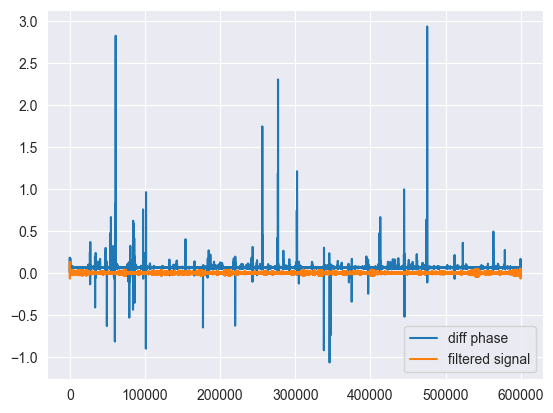

In [112]:
plt.plot(diff_phase, label='diff phase')
plt.plot(df['Filtered Signal'], label = 'filtered signal')
plt.legend()
plt.show()

In [124]:
correlation = []
windows =  np.array_split(diff_phase, 100)
signal_windows = np.array_split(df['Filtered Signal'], 100)

for window in windows:
    mean = np.mean(window)
    aux = np.correlate(window-mean, window, mode='same')
    
    correlation.append(aux)
    

correlation = np.array(correlation)


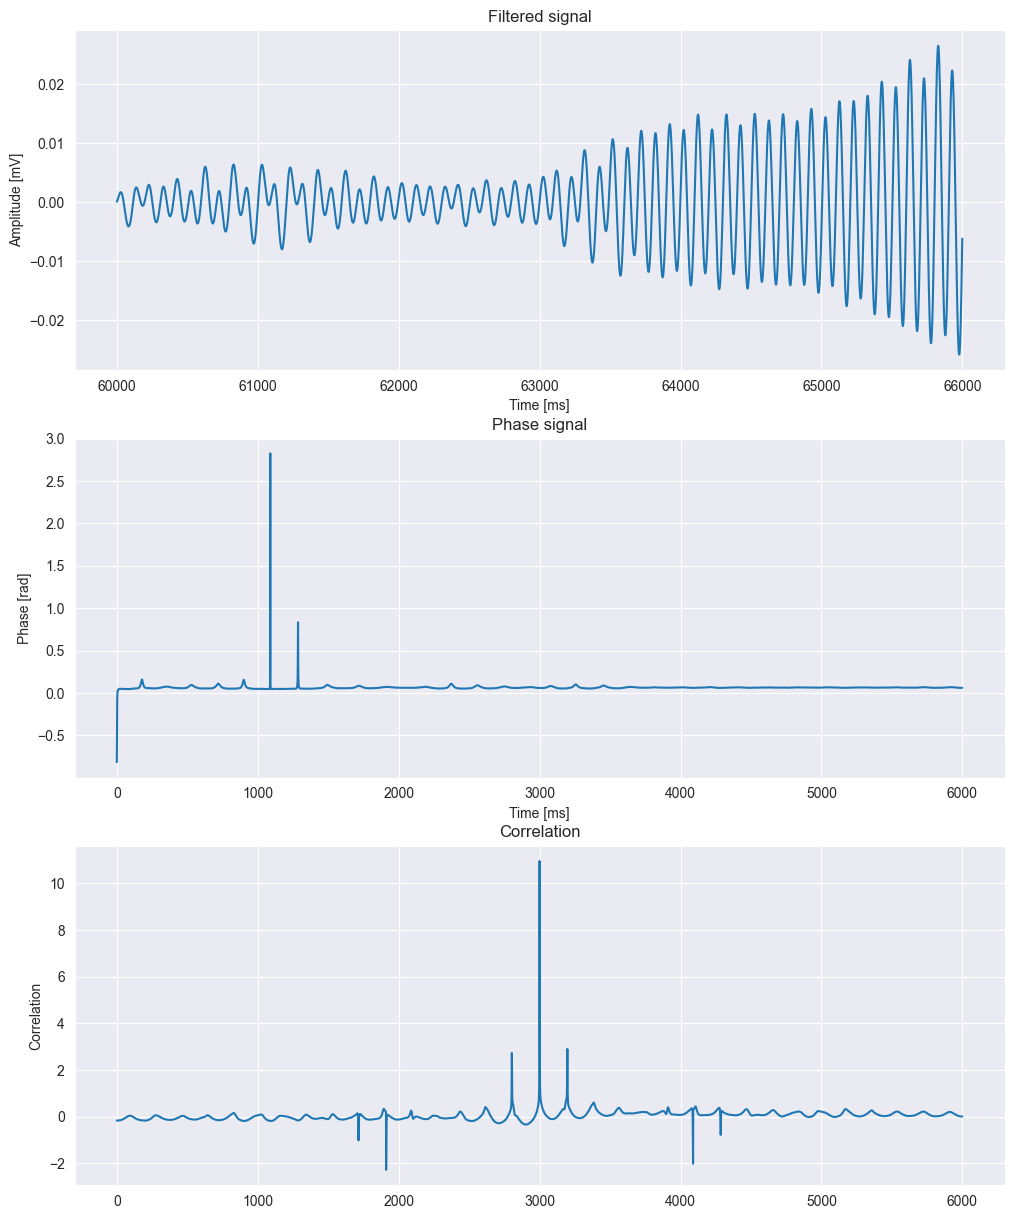

In [125]:
figure, axis = plt.subplots(3, 1, figsize=(12, 15))
axis[0].plot(signal_windows[10])
axis[0].set_xlabel('Time [ms]')
axis[0].set_ylabel('Amplitude [mV]')
axis[0].set_title('Filtered signal')

axis[1].plot(windows[10])
axis[1].set_xlabel('Time [ms]')
axis[1].set_ylabel('Phase [rad]')
axis[1].set_title('Phase signal')

axis[2].plot(correlation[10])
axis[2].set_ylabel('Correlation')
axis[2].set_title('Correlation')

plt.show()

In [126]:
df_correlation = pd.DataFrame(correlation)

#### **kmeans**
se supone que hay cosas parecida, voy a ver si con la autocorrelación se pueden hacer clusters, primero voy a intentarlo con kmeans y luego con dbscan.

In [127]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_correlation)
labels = kmeans.predict(df_correlation)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [133]:
labels = pd.DataFrame(labels)
labels.value_counts()

0    88
2     9
1     3
Name: count, dtype: int64

Se toman los cluster 1 y 3 para verlos más a fondo.

In [134]:
df_correlation['labels'] = labels
df_clusters = df_correlation[df_correlation['labels'].isin([1,2])]
df_clusters.shape

(12, 6001)

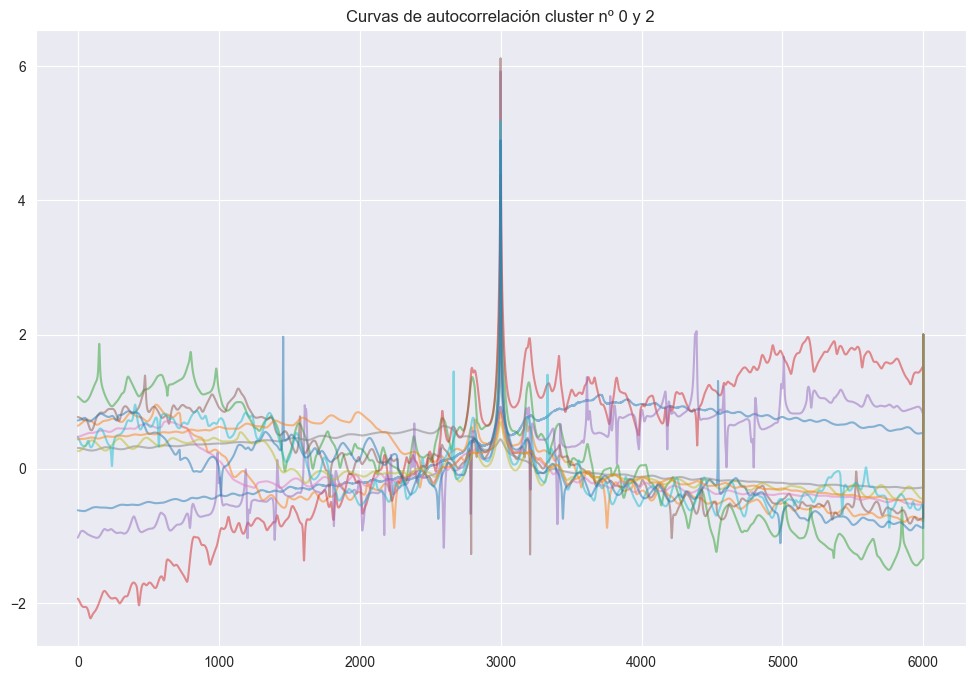

In [135]:
plt.figure(figsize=(12, 8))

for elem in df_clusters.index:
    plt.plot(df_clusters.loc[elem, :].values, label = f'curva cluster {df_clusters.loc[elem, 'labels']}', alpha = 0.5 )

#plt.legend()
plt.title('Curvas de autocorrelación cluster nº 0 y 2')
plt.show()

In [136]:
df_clusters.index

Index([0, 5, 9, 13, 14, 16, 27, 43, 48, 50, 57, 61], dtype='int64')

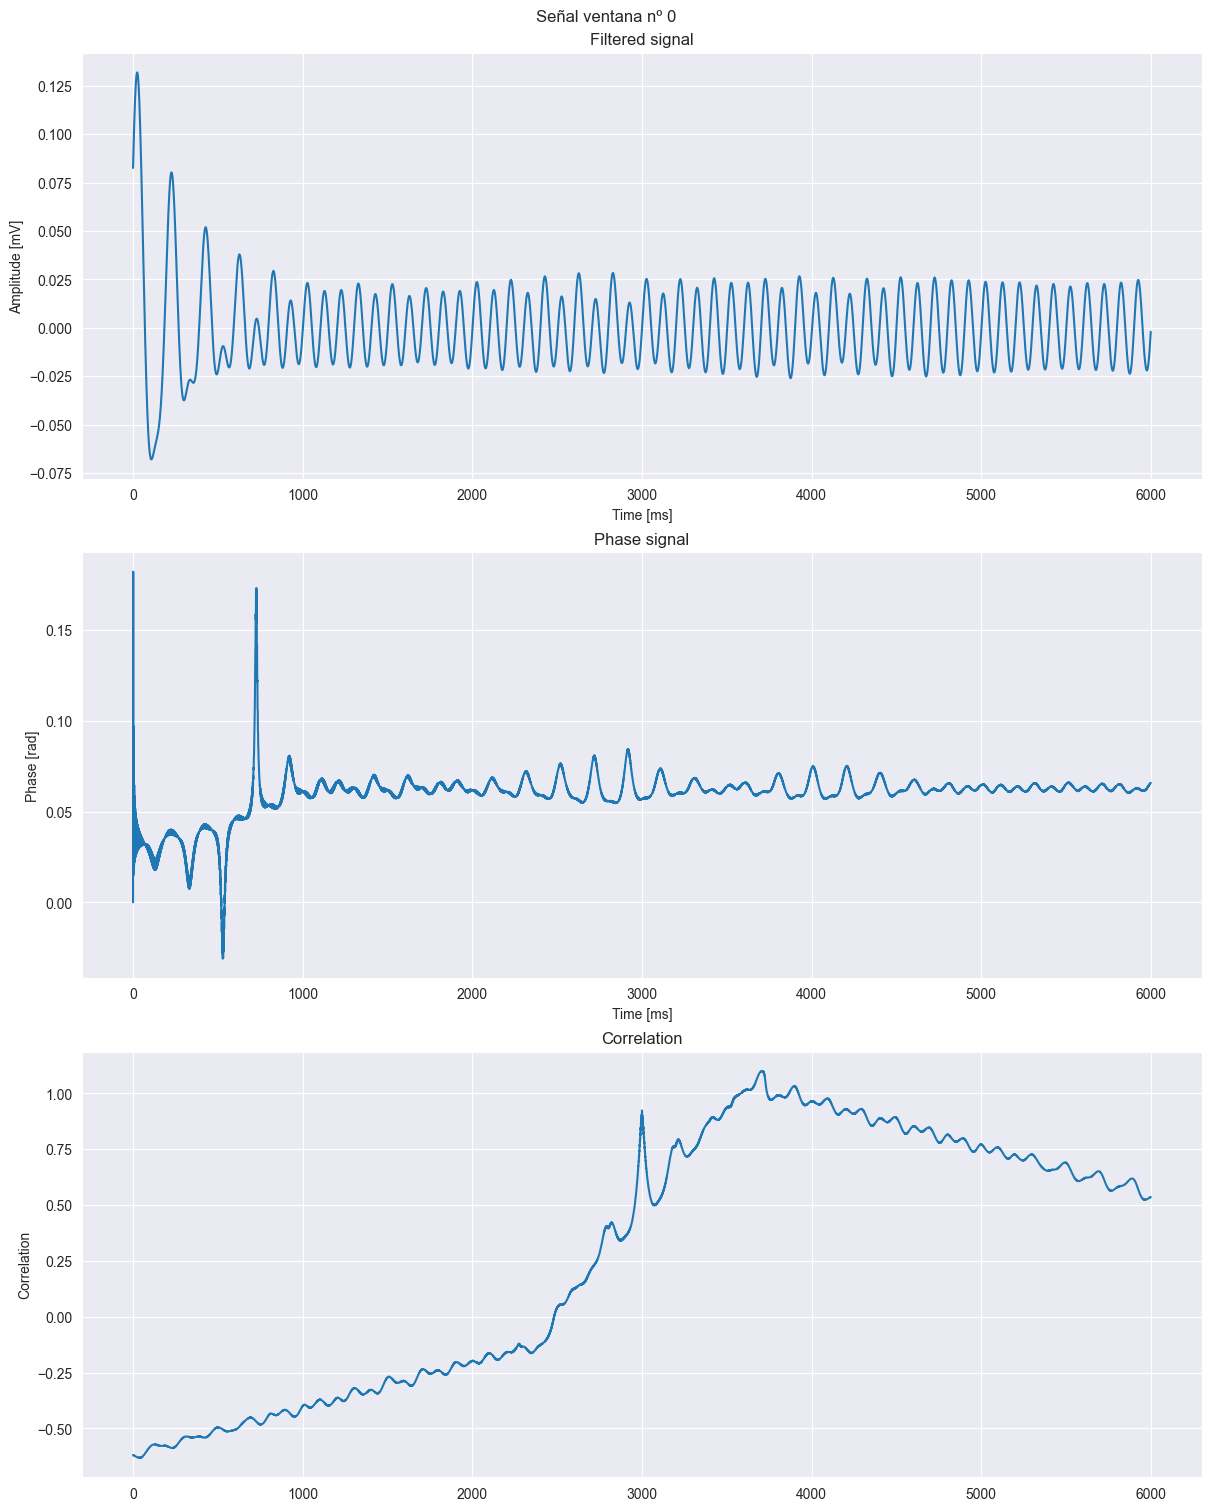

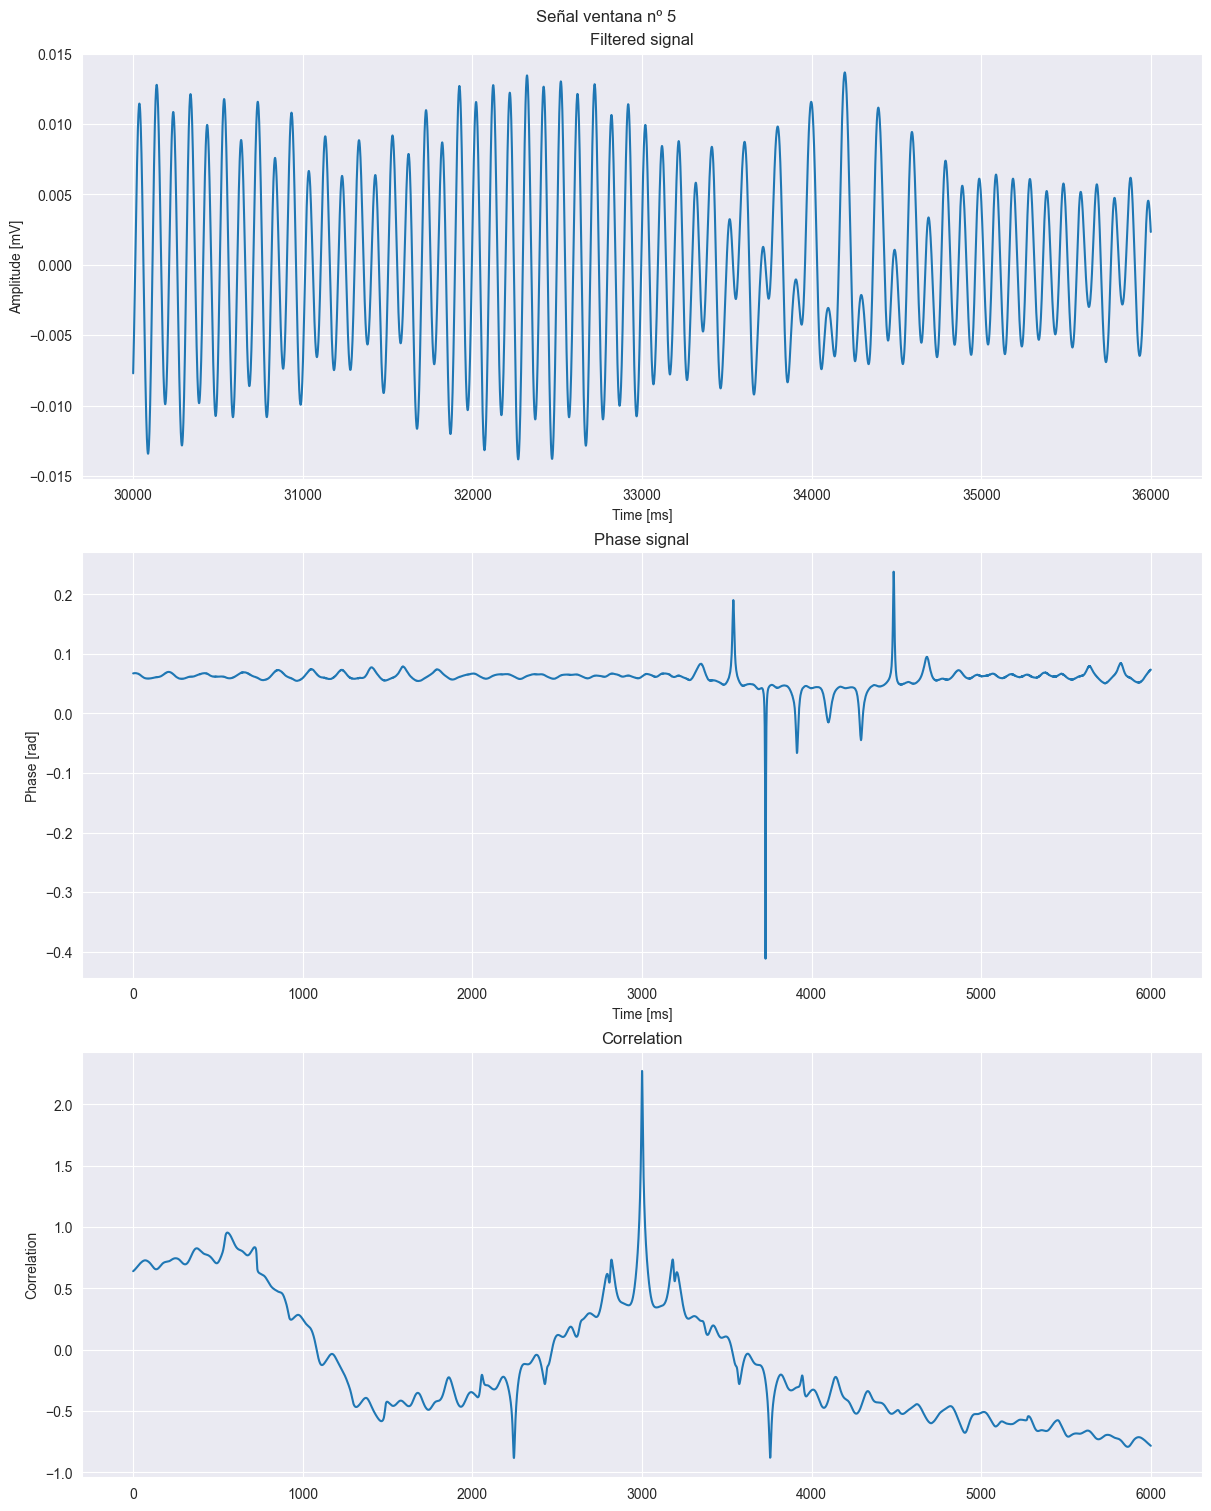

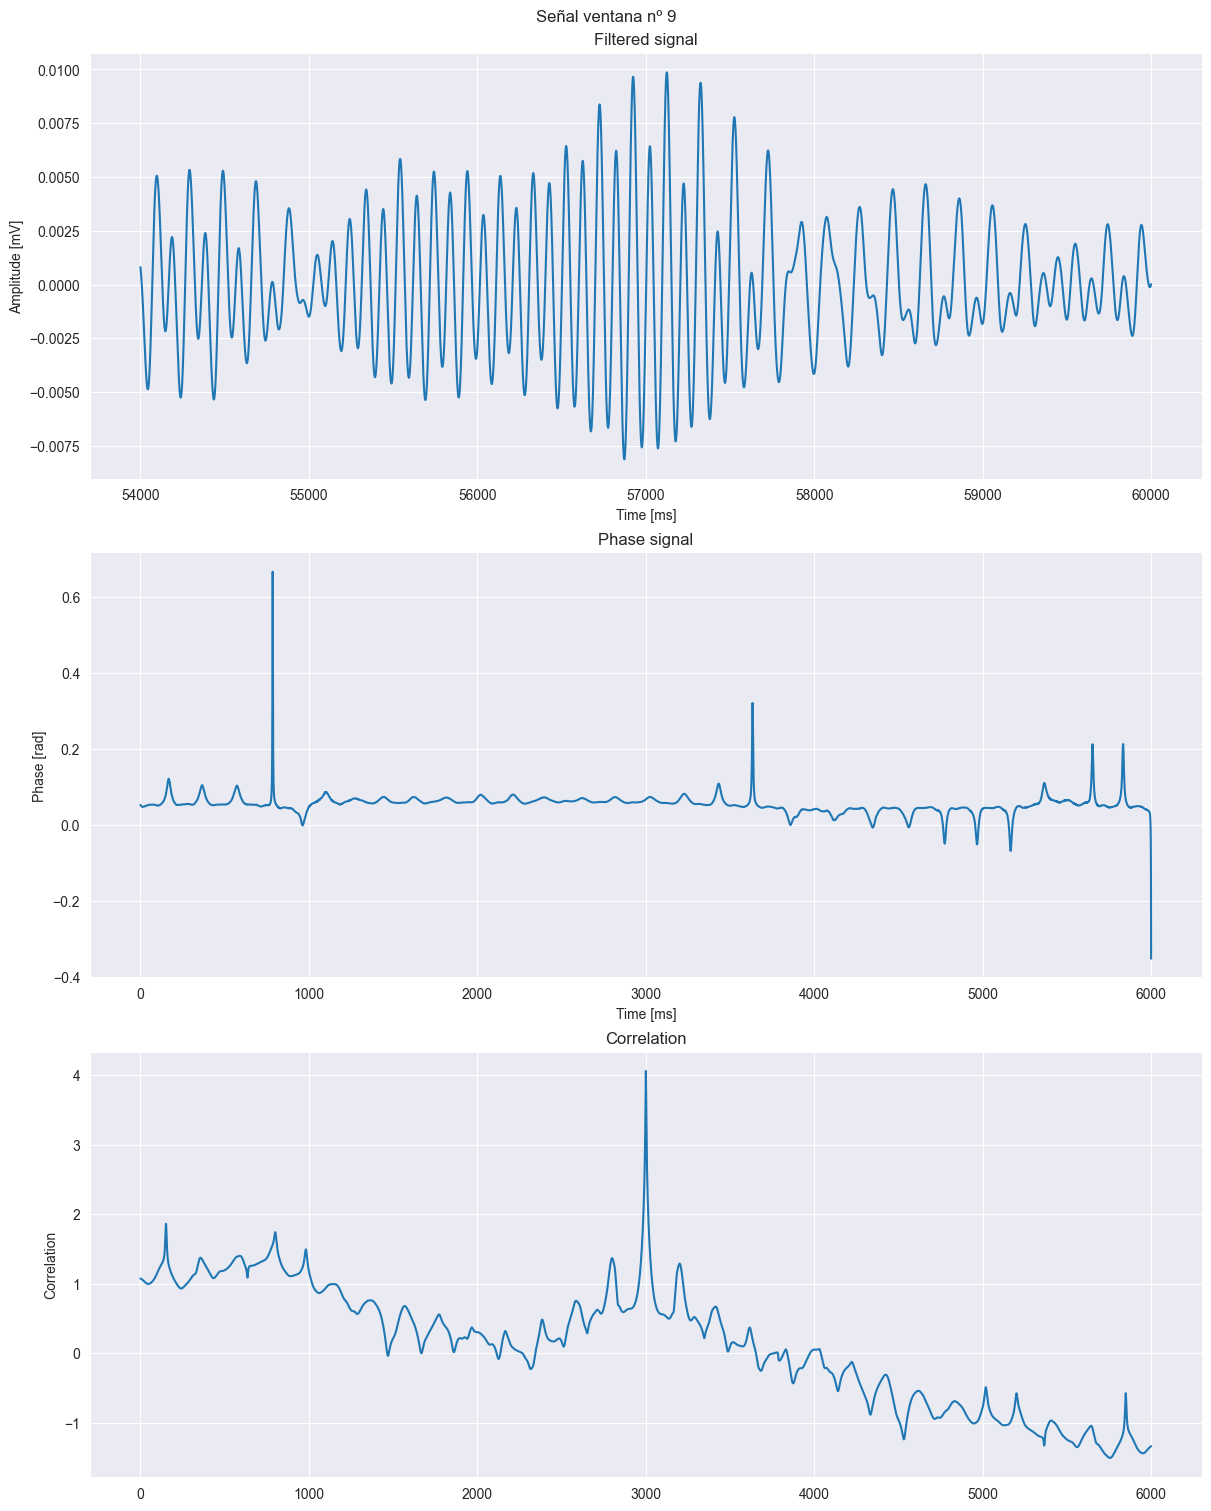

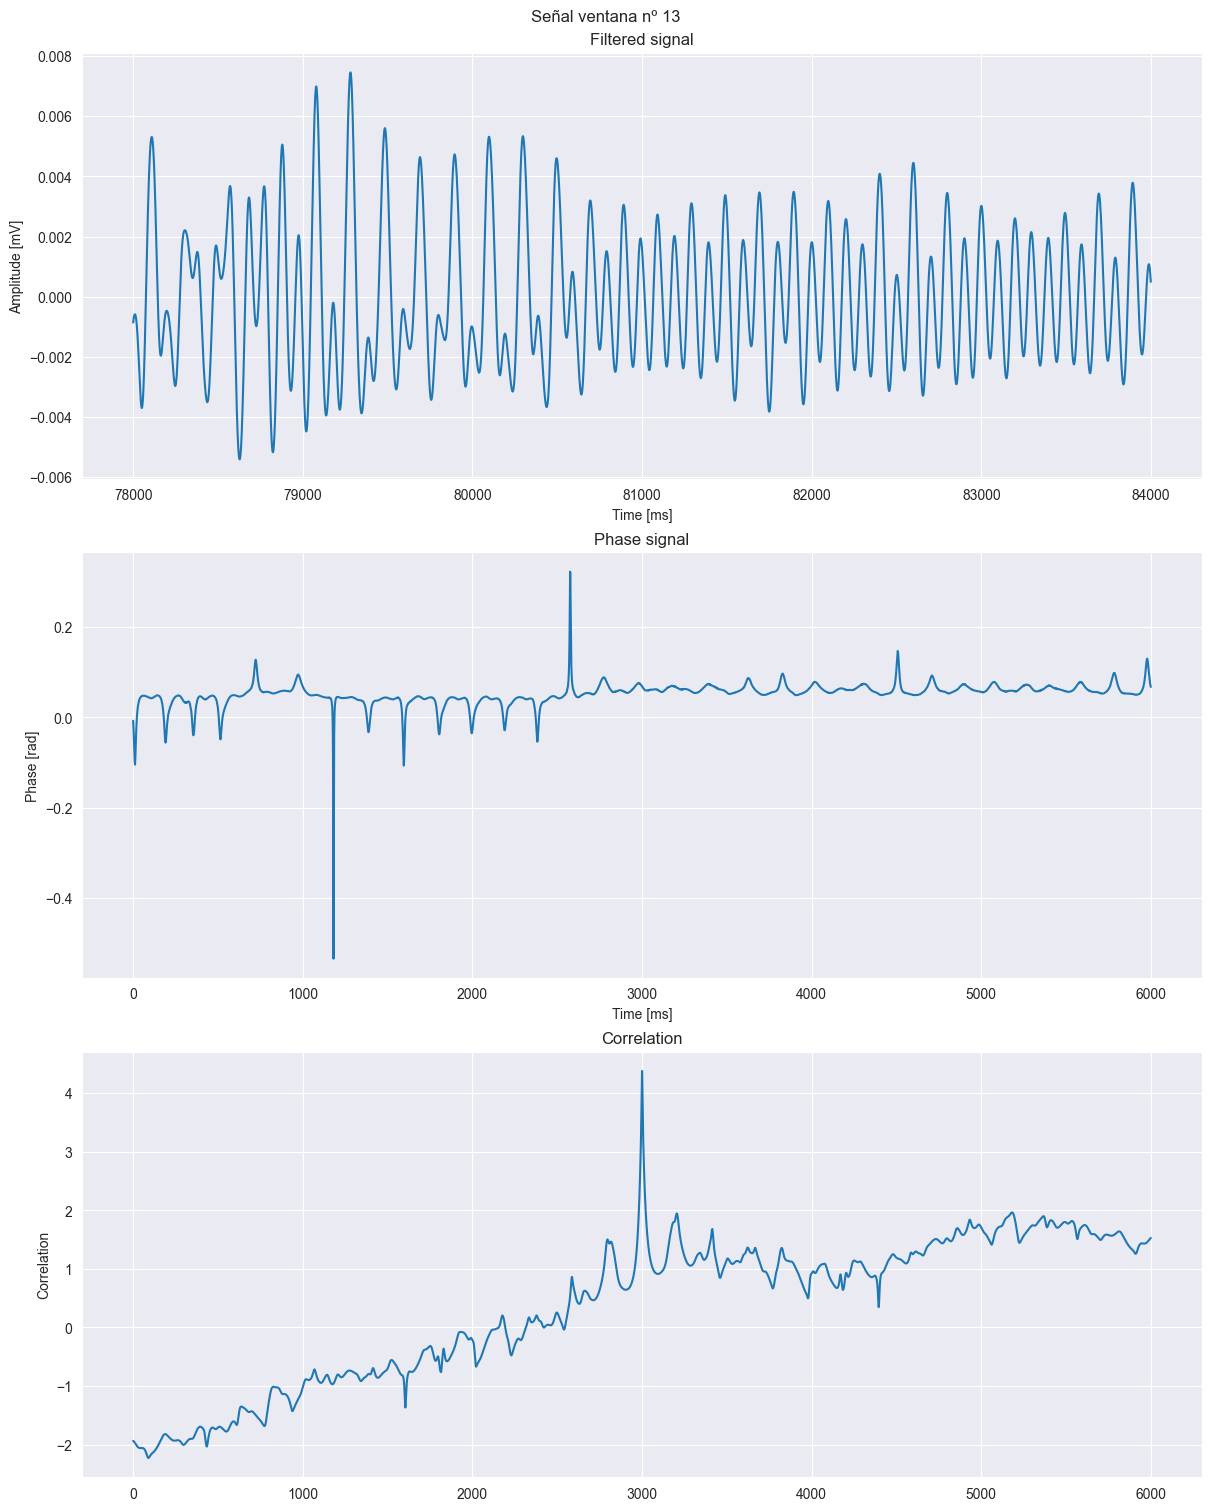

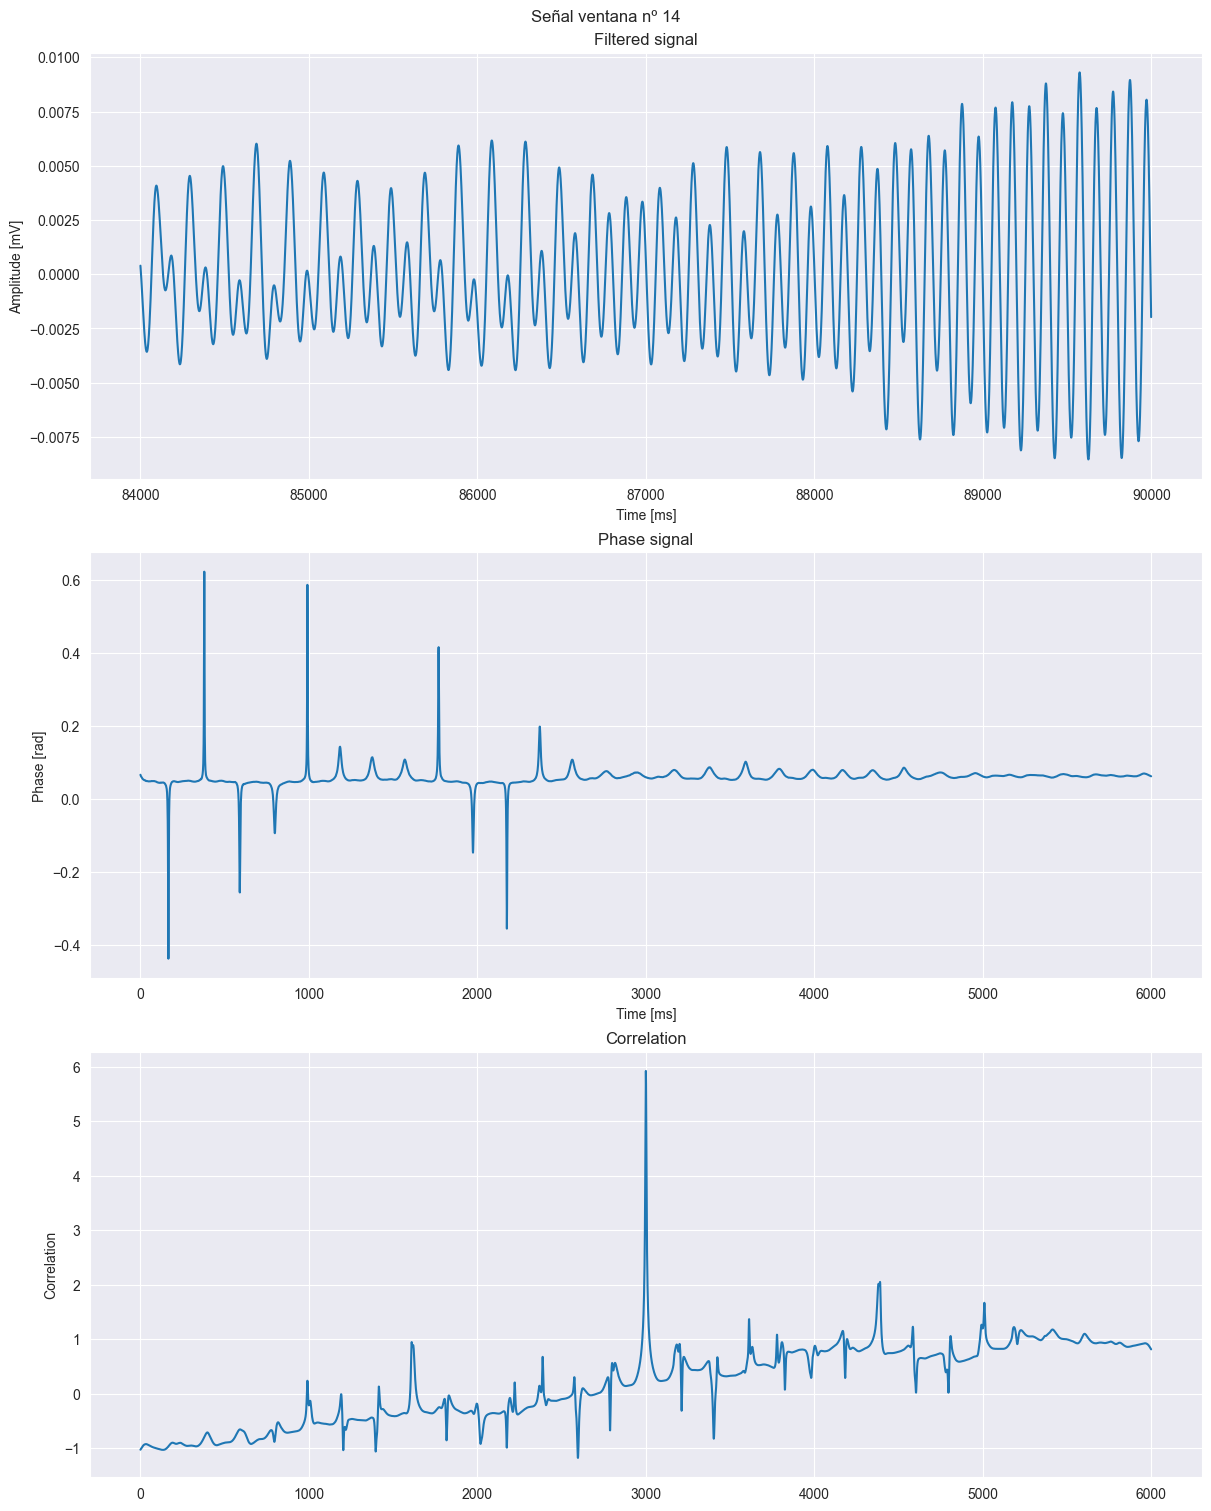

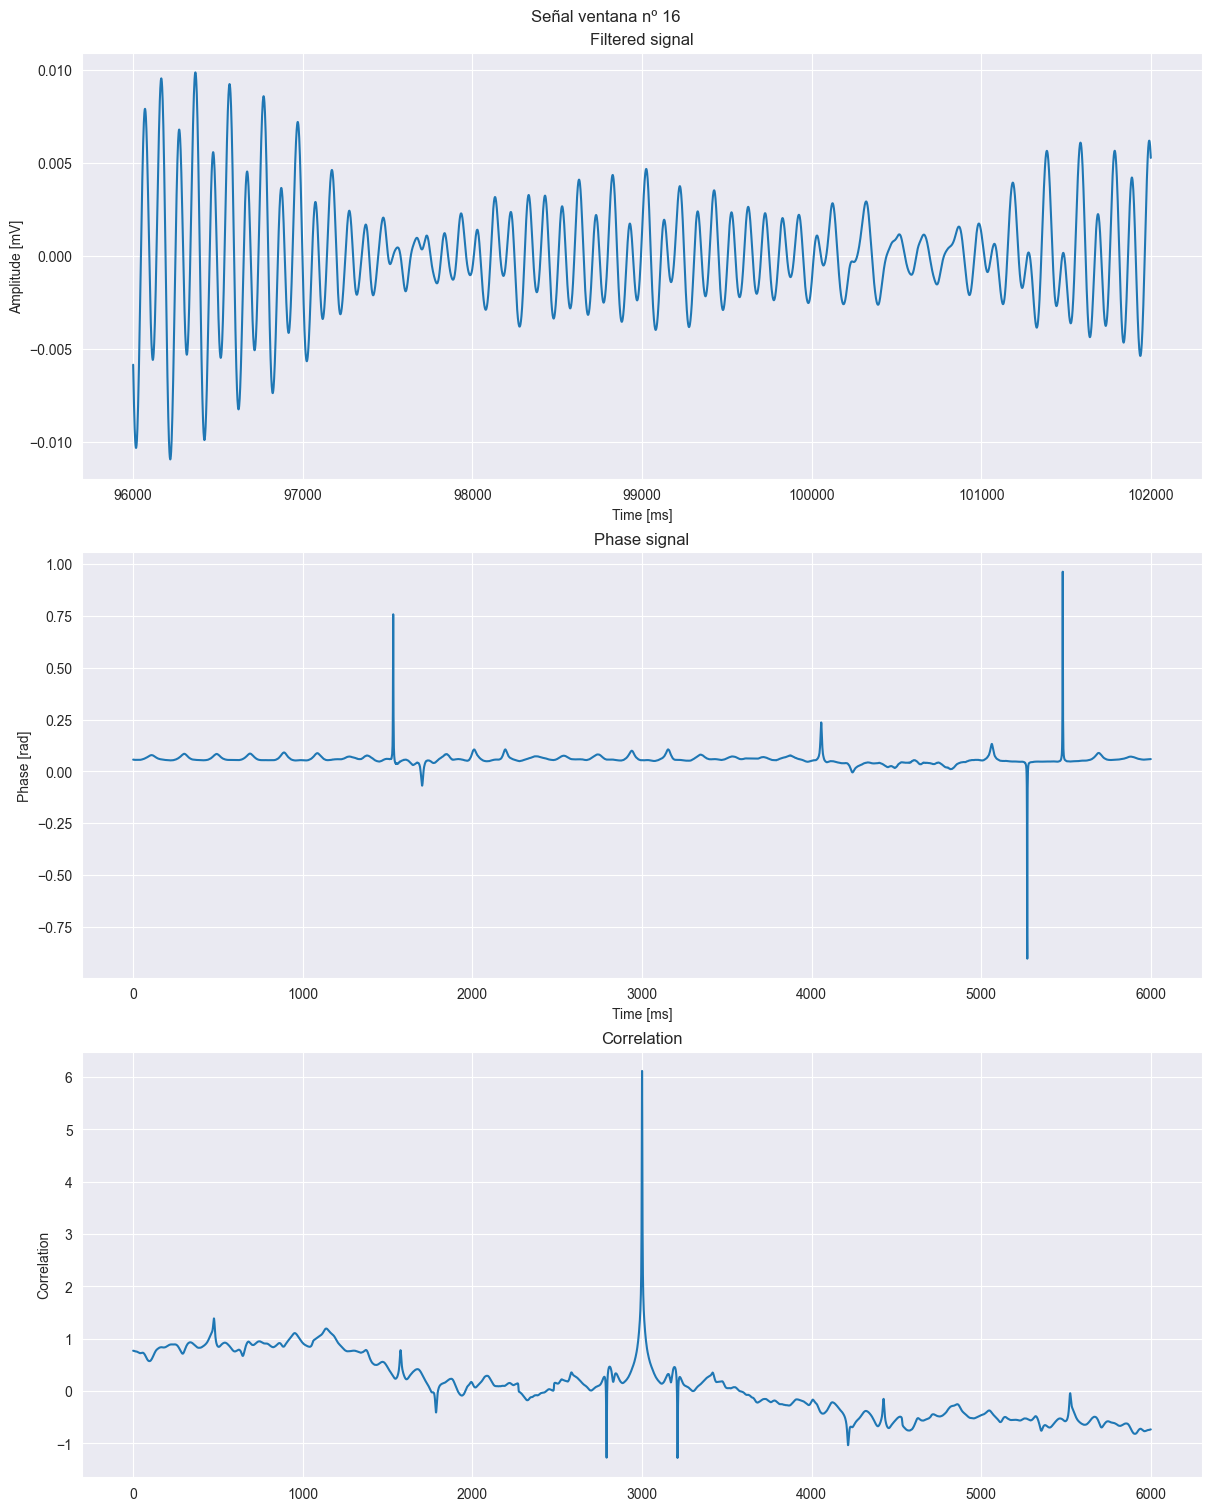

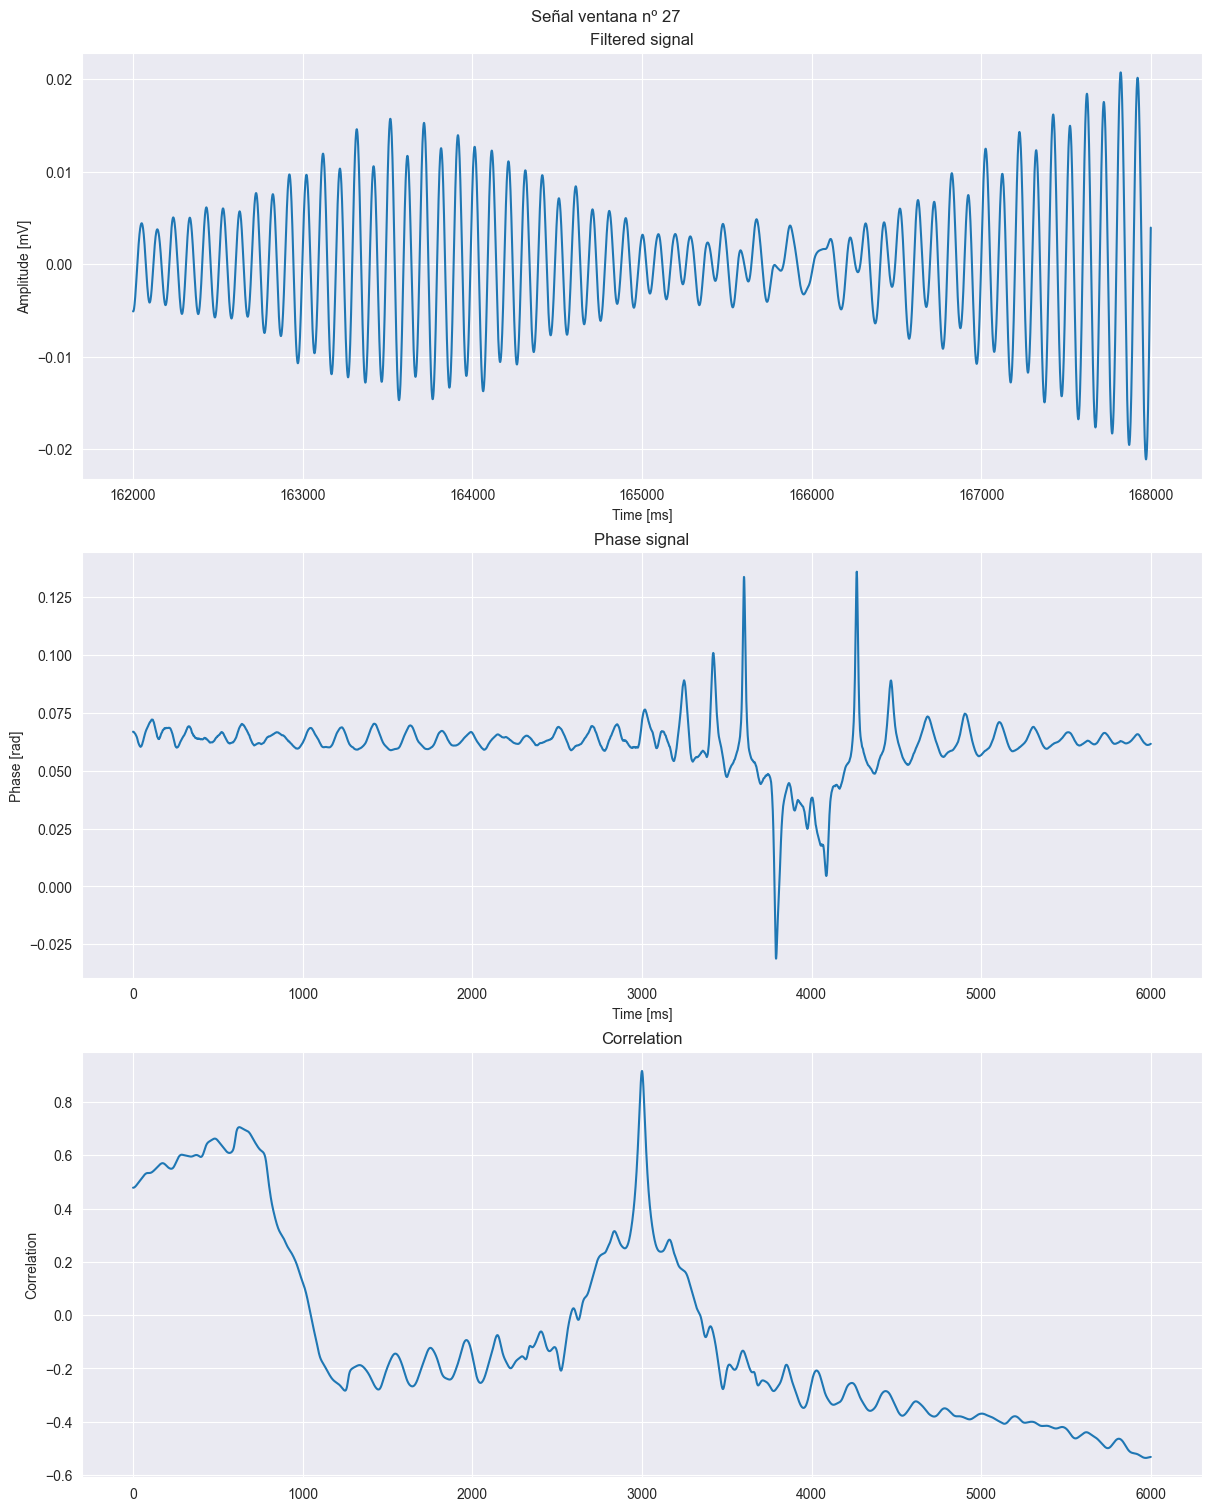

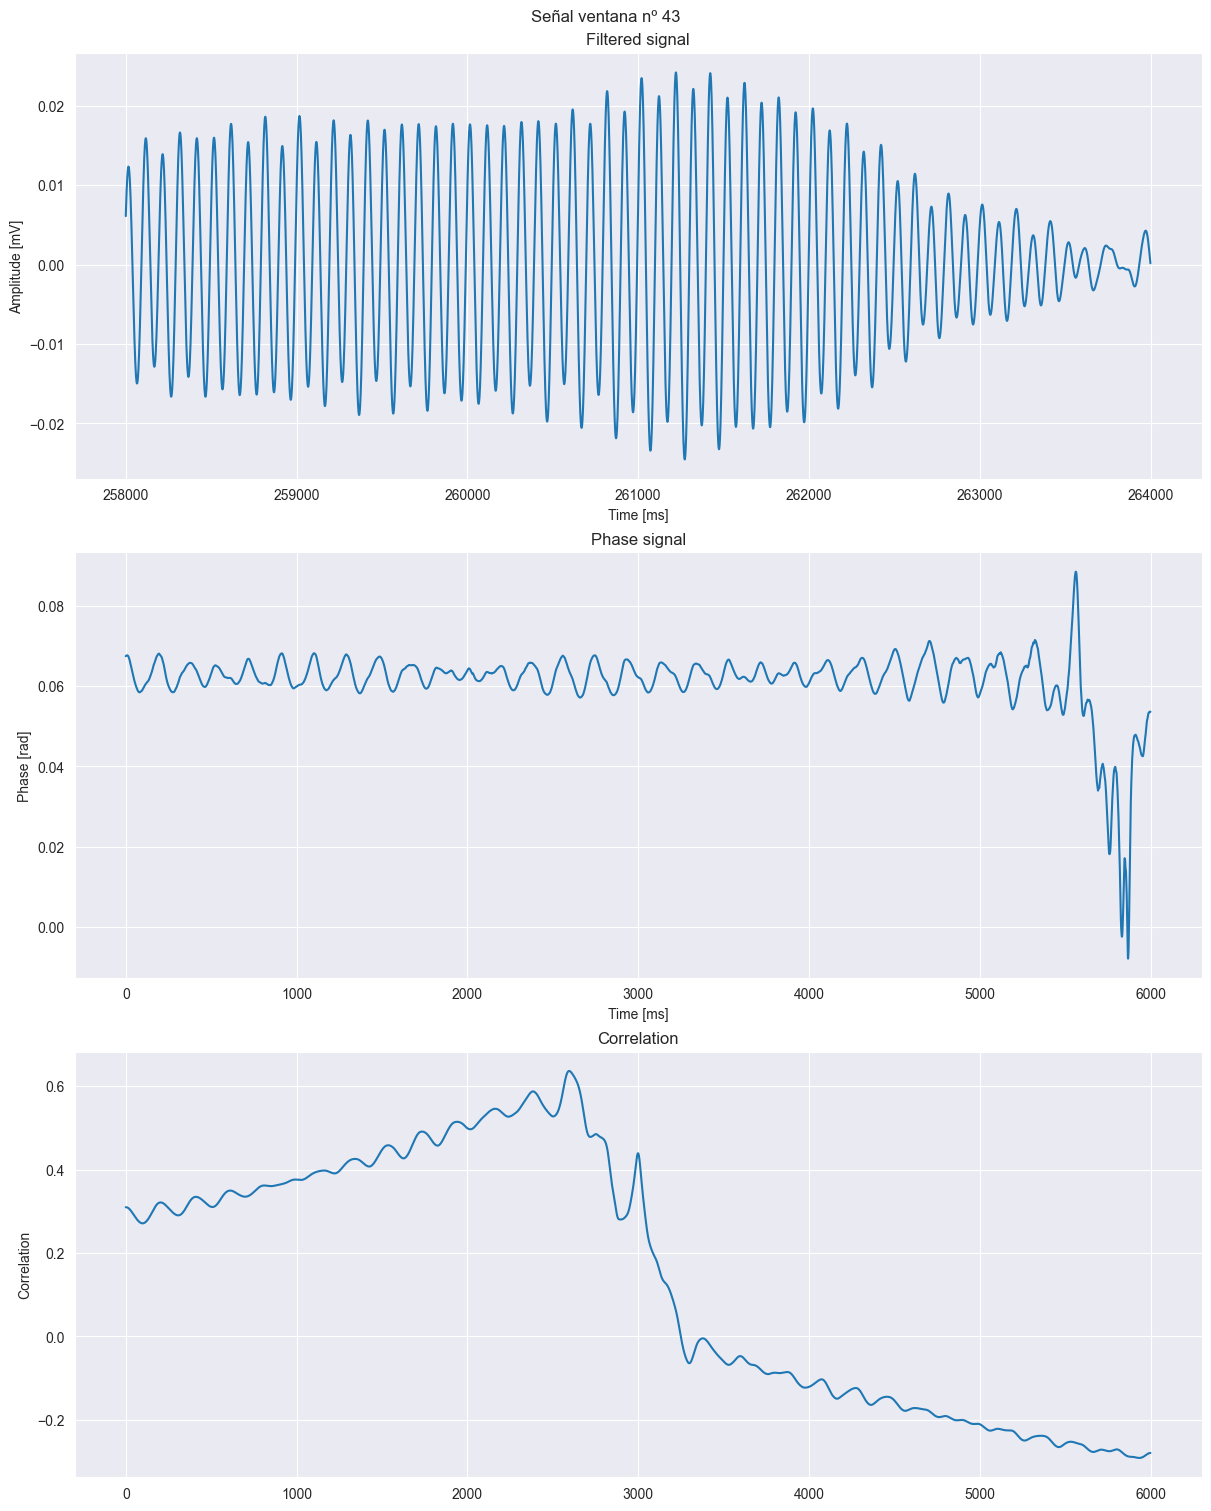

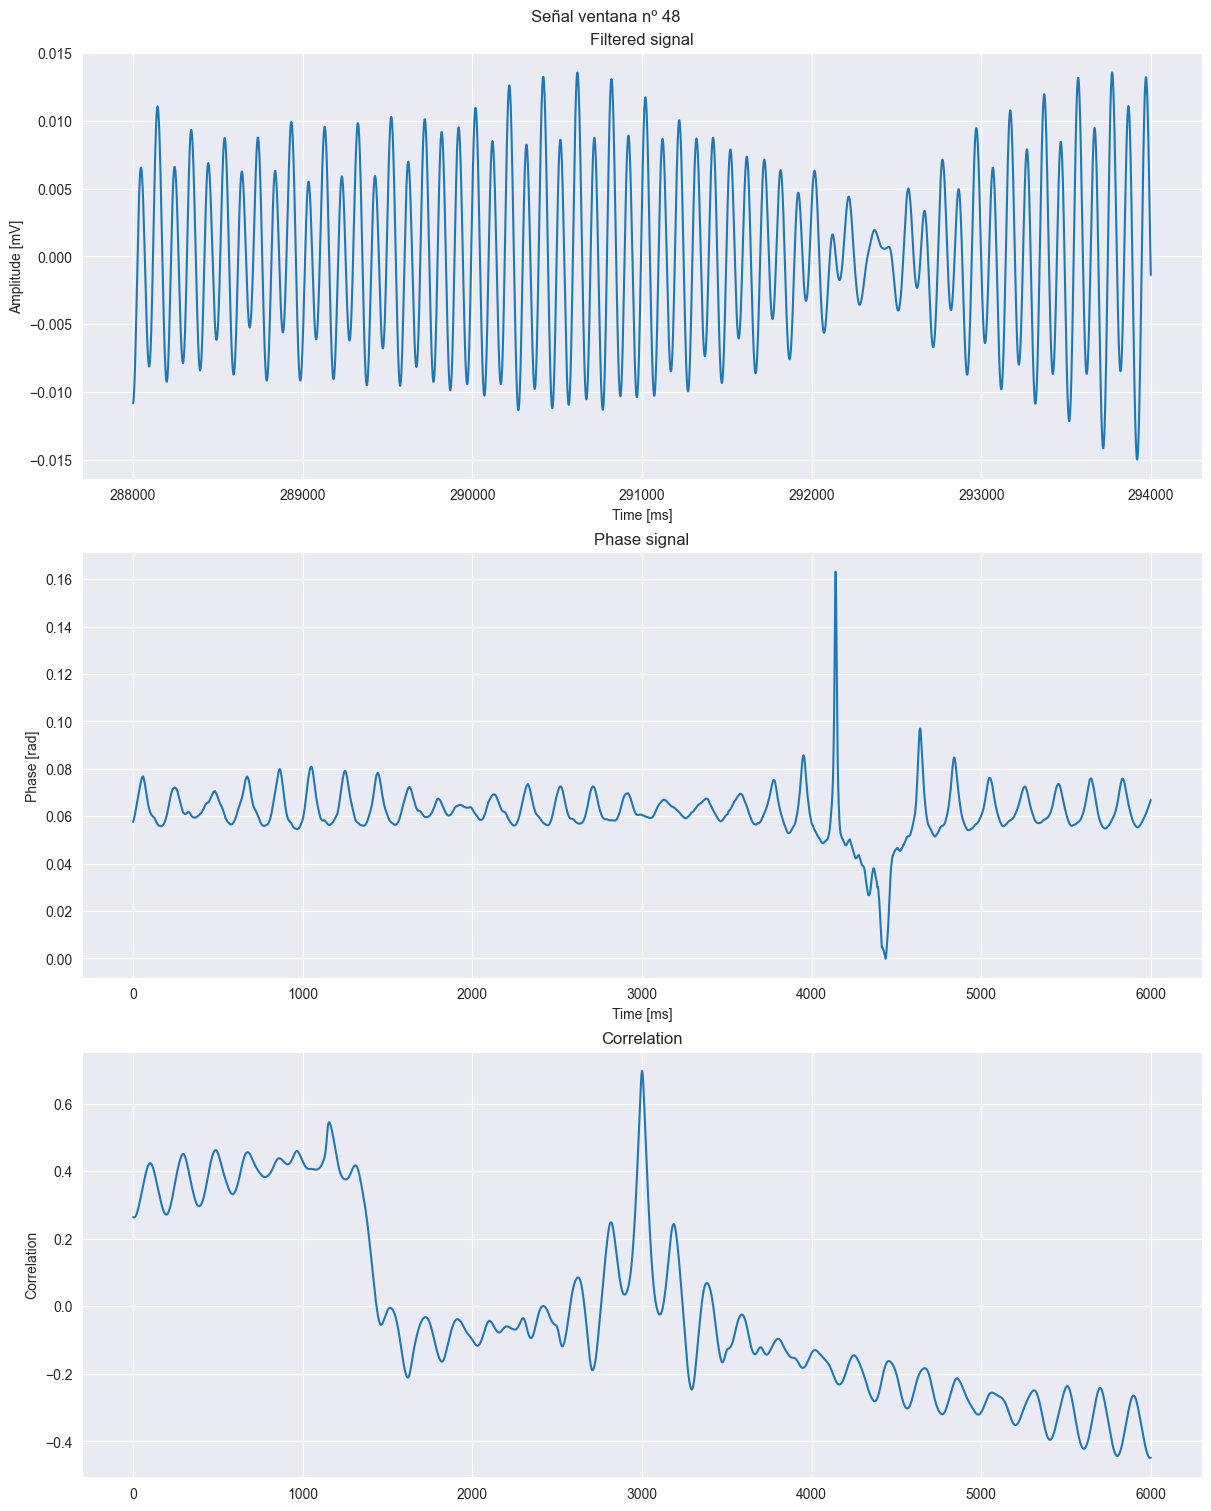

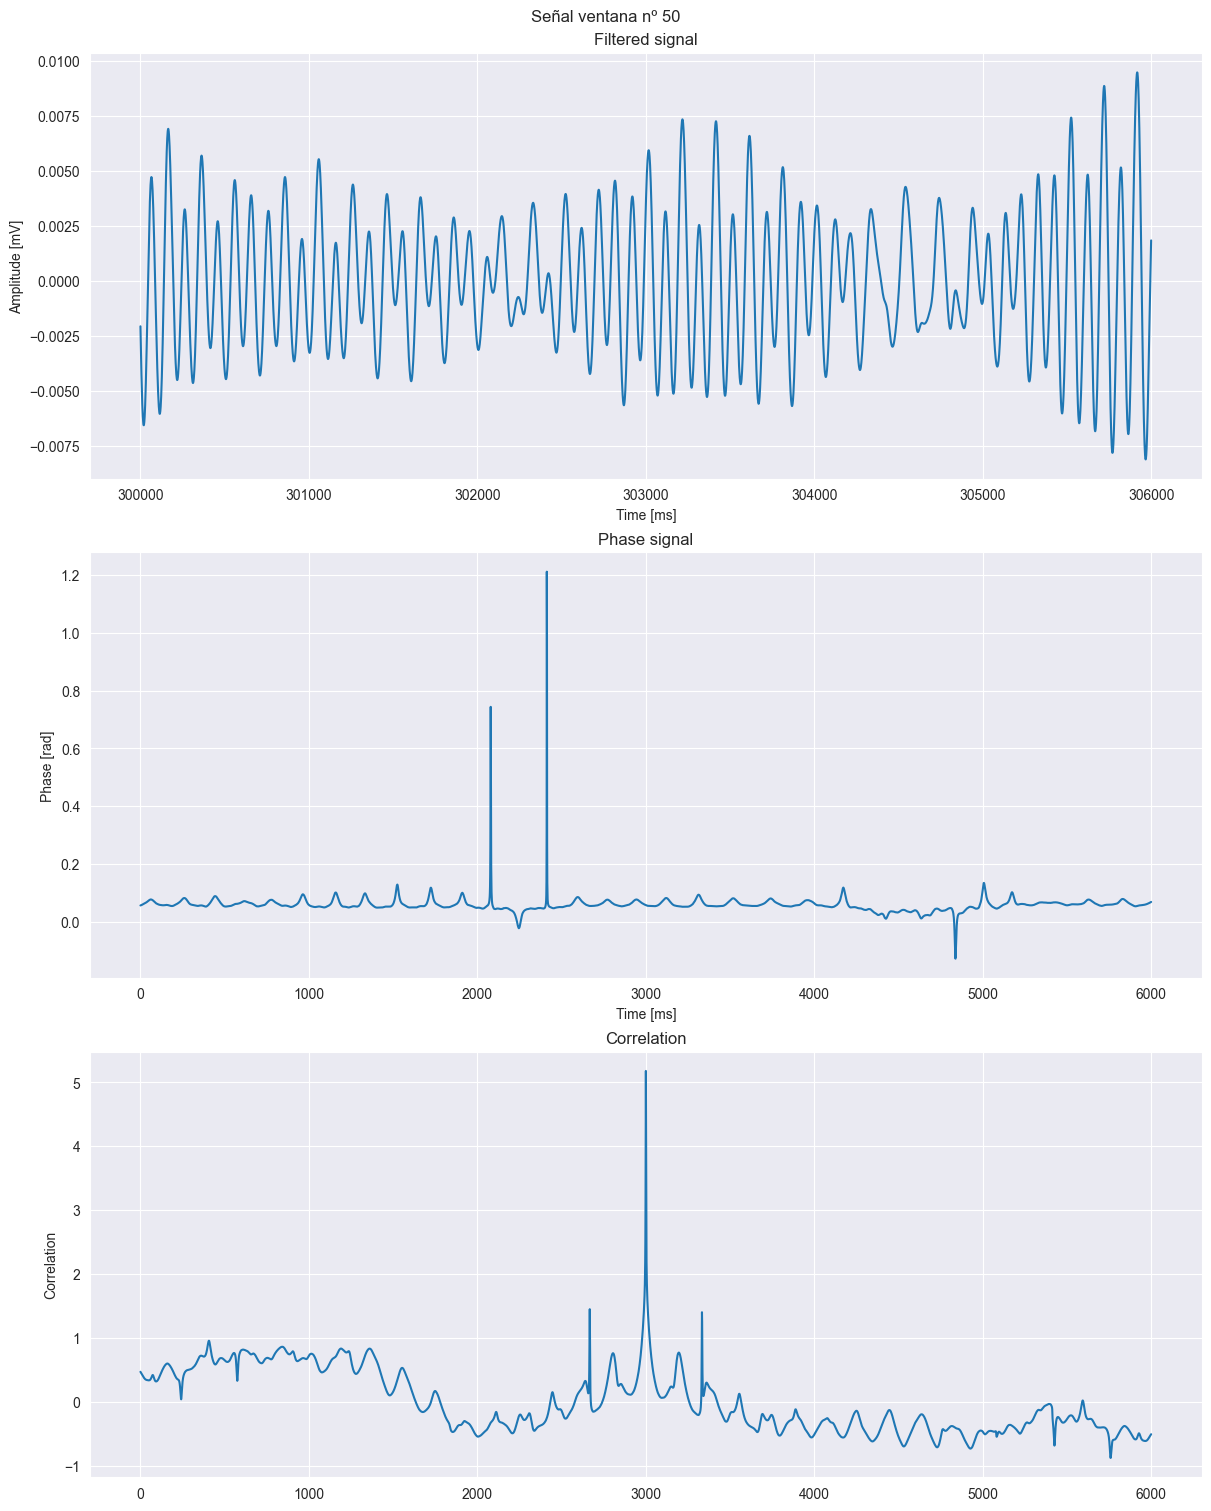

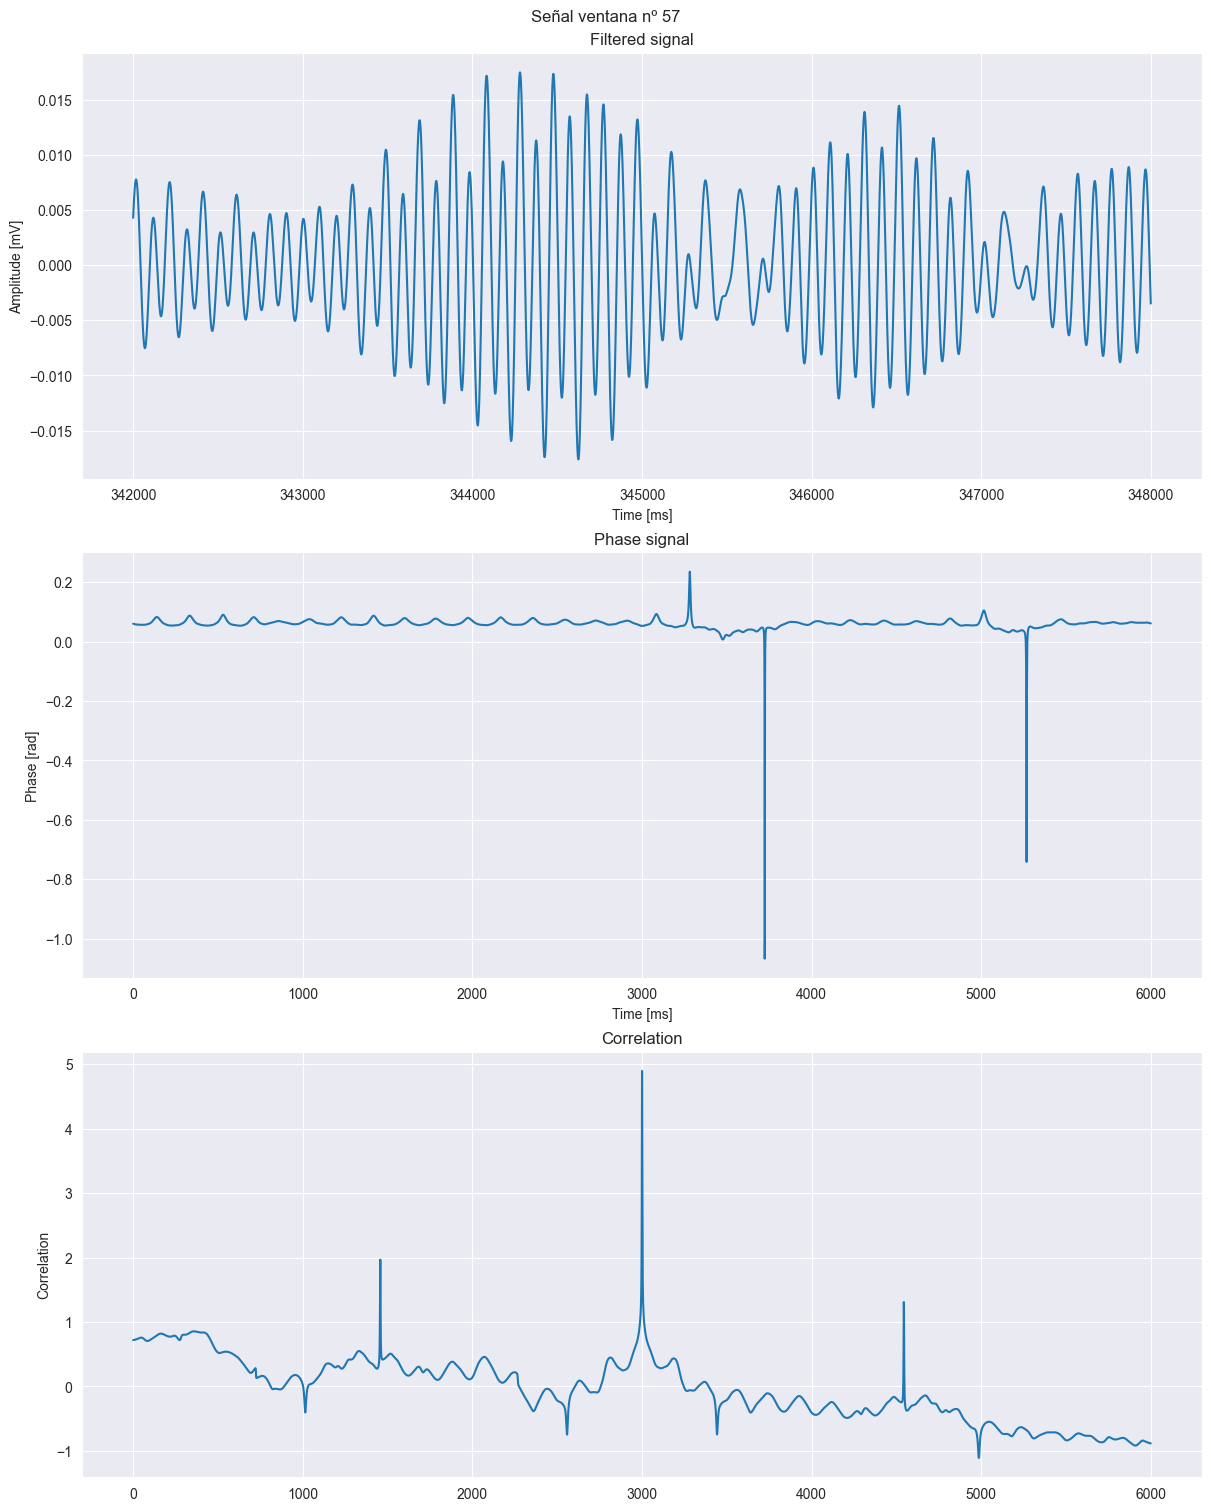

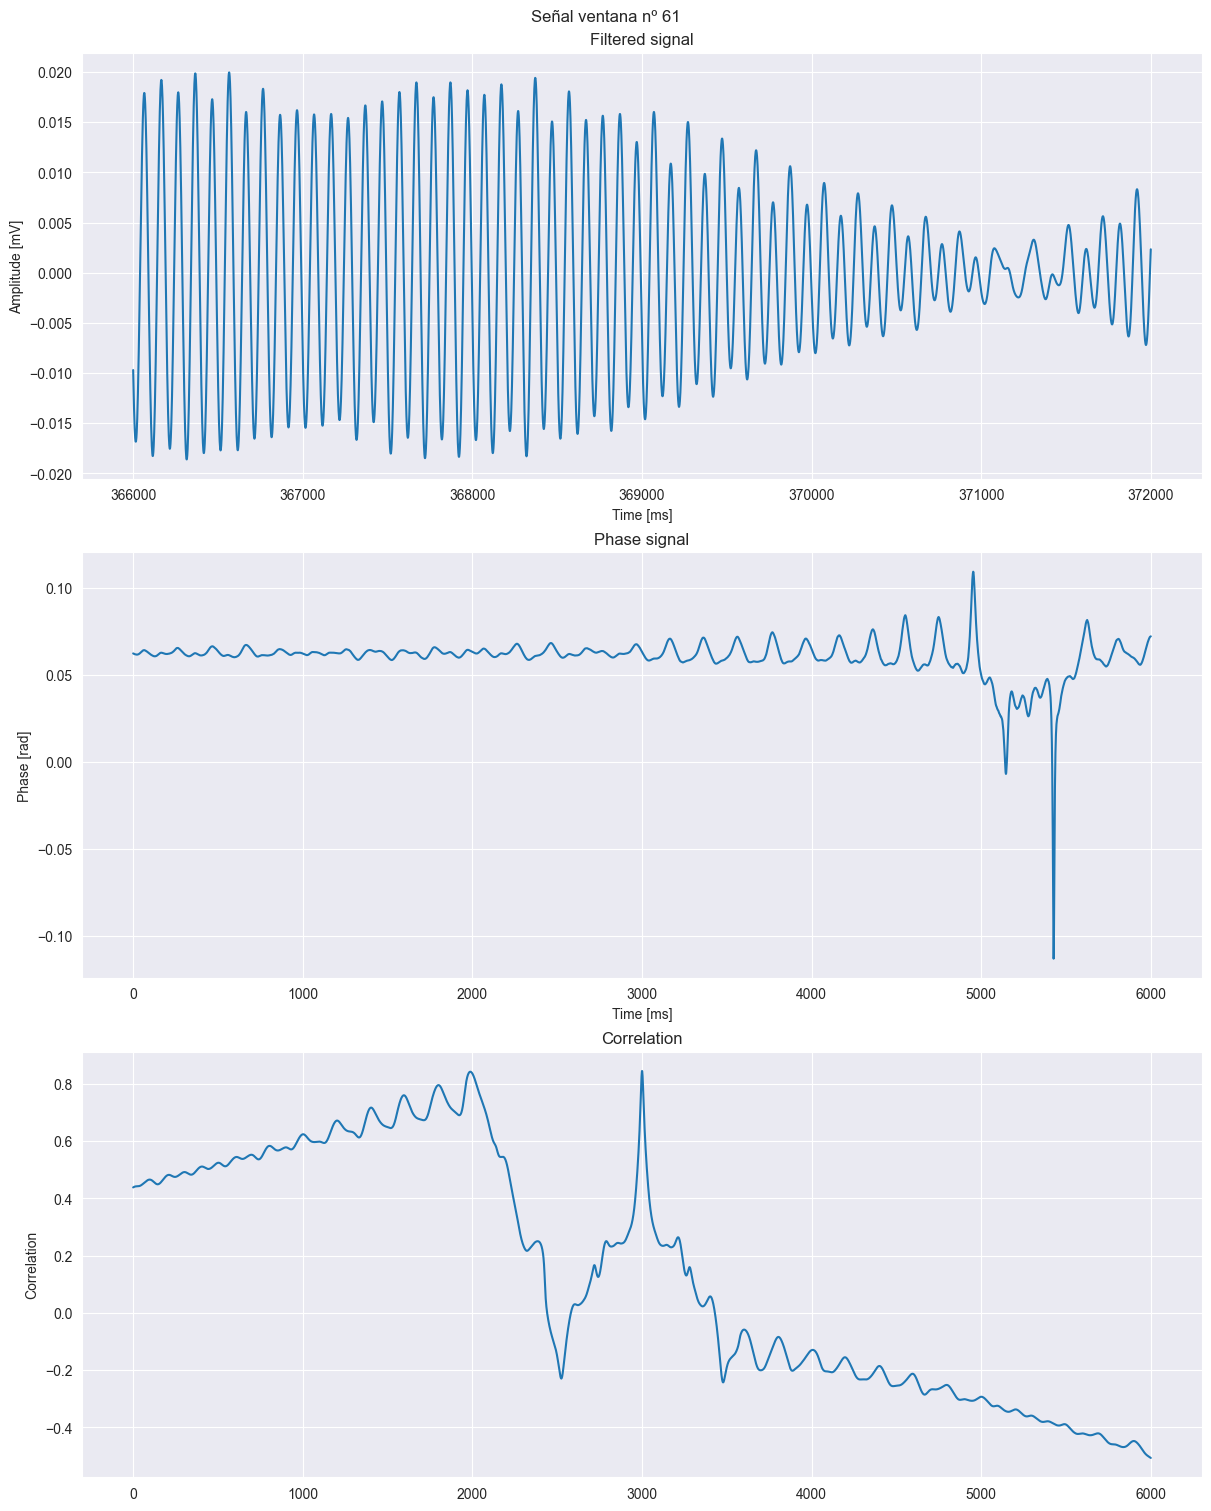

In [139]:
for elem in df_clusters.index:
    figure, axis = plt.subplots(3, 1, figsize=(12, 15), constrained_layout=True)
    figure.suptitle(f'Señal ventana nº {elem}')
    axis[0].plot(signal_windows[elem])
    axis[0].set_xlabel('Time [ms]')
    axis[0].set_ylabel('Amplitude [mV]')
    axis[0].set_title('Filtered signal')

    axis[1].plot(windows[elem])
    axis[1].set_xlabel('Time [ms]')
    axis[1].set_ylabel('Phase [rad]')
    axis[1].set_title('Phase signal')

    axis[2].plot(correlation[elem])
    axis[2].set_ylabel('Correlation')
    axis[2].set_title('Correlation')

    plt.show()